# Stock Trend based on Fundamentals
Predicting stock performance for the next quarter based on quarterly fundamental financials. 

__Classification Problem__

__Classes__
- Buy: Price high and Price low increase by 3% or more in the next quarter.
- Sell: Price high and Price low decrease by -3% or more in the next quarter
- Hold: If neither happen 

For our fundamental data (Shares, Assets, etc.), we will be observing two QRs to create new values. The changes from the previous QR to the current or present QR will be measured as a percent change instead of their actual value.


# Imports

In [1]:
# install dependencies except sklearn, numpy, pandas
!pip3 install xgboost
!pip3 install auto-sklearn

In [2]:
# data manipulating
import pandas as pd
import numpy as np

# plotting and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning utils from sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.utils.multiclass import type_of_target
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# auto ml
import autosklearn.classification

/home/kaypee/miniconda3/envs/ds/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


# Importing the Generated Data

In [3]:
# import datasets
X_raw = pd.read_csv("../Datasets/dataset_normalised.csv")
y_raw = pd.read_csv("../Datasets/labnf.csv")

# numberical column that are needed for training
numeric_columns=['Shares (Basic)',
       'Shares (Diluted)', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Investments & Receivables', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Short Term Debt', 'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Treasury Stock',
       'Retained Earnings', 'Total Equity', 'Total Liabilities & Equity',
       'Price_Present']

# the final X and Y 
X = X_raw[numeric_columns]
y = y_raw["Label"]

## Exploratory Data Analysis (EDA) 

### Histogram plot
Determining the underlying frequency Distribution of data

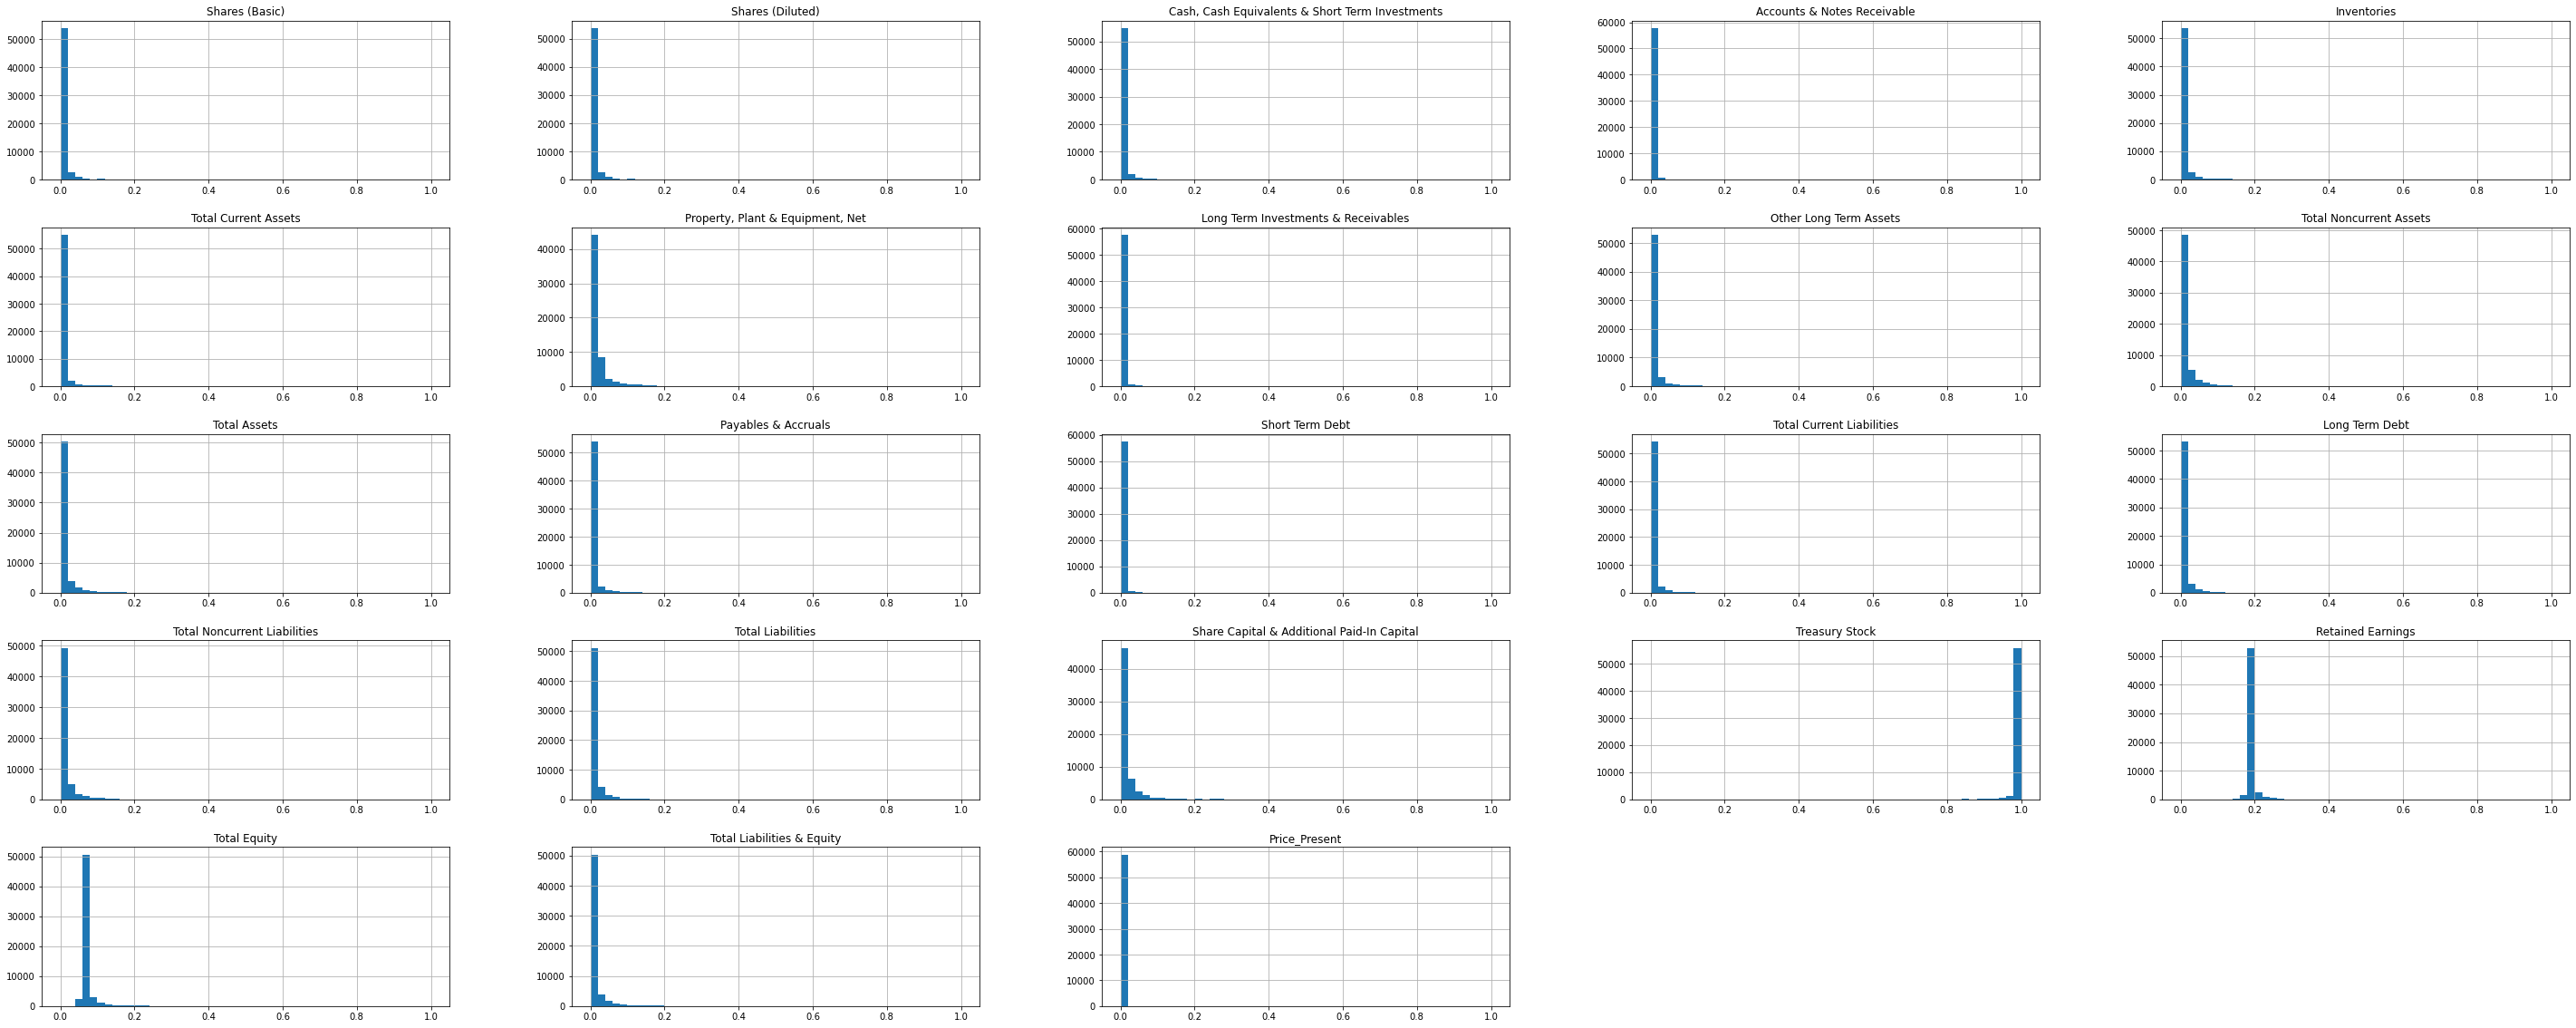

In [4]:
# plotting the hist of feature space
X.hist(bins=50,figsize=(50,20))

Most of the input parameter are exponentially distributed

<AxesSubplot:>

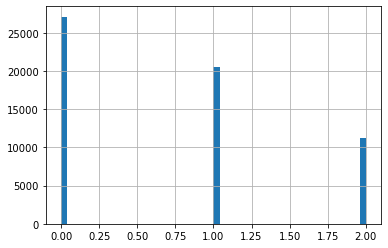

In [4]:
y.hist(bins=50)

> The dataset has a huge difference between the records resulting in label2 and label0

### Correlation Plot
Finding dependencies among multiple variables

<AxesSubplot:>

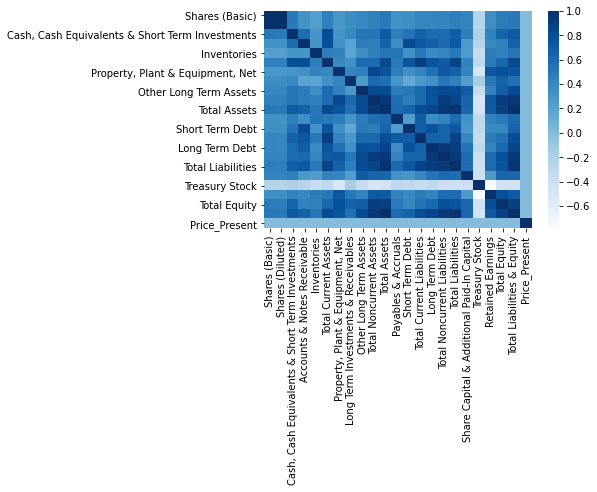

In [5]:
sns.heatmap(X.corr(),cmap="Blues")

Our dataset is highly correlated, this may impact the model performace. 

__Problem__

__Multicollinearity__ happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This leads to skewed or misleading results

- Decision trees are immune to this problem.

We try to eliminate this problem by using PCA when using other models

### PCA 

#### Visualizing the labels in PCA (n_components=2)

Since PCA, emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize.

In [10]:
pca=PCA(n_components=2).fit(X)
X_pca2=pca.transform(X)
print(pca.explained_variance_ratio_)

[0.60399844 0.09185522]


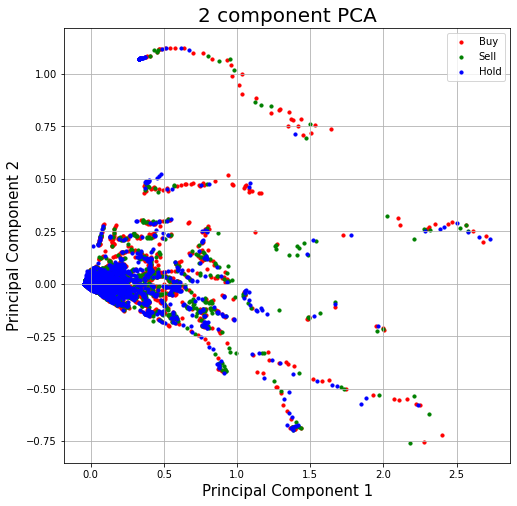

In [11]:
# creating a DataFrame for pca 
pcadf=pd.DataFrame()
pcadf['principal component 1']=X_pca2[:,0]
pcadf['principal component 2']=X_pca2[:,1]
pcadf['target_numeric']=y
pcadf['target']=""
pcadf.loc[pcadf['target_numeric'] == 0,'target'] = 'Buy'
pcadf.loc[pcadf['target_numeric'] == 1,'target'] = 'Sell'
pcadf.loc[pcadf['target_numeric'] == 2,'target'] = 'Hold'


# plotting labels in PCA(n_components=2)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Buy', 'Sell','Hold']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pcadf['target'] == target
    ax.scatter(pcadf.loc[indicesToKeep, 'principal component 1']
               , pcadf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

A clear trend seperating the three labels is not apparent when visualizing it with PCA(n_components=2)

#### PCA Dimensionality Reduction

In [12]:
# standardizing data

scaler = StandardScaler()# Fit on training set only.
scaler.fit(X)
X_scalar = scaler.transform(X)

In [13]:
# using default pca
pca = PCA(0.9999)
X_pca = pca.fit_transform(X_scalar)

In [14]:
pca.explained_variance_ratio_

array([5.61005316e-01, 8.41894283e-02, 6.76566641e-02, 5.35565902e-02,
       4.35077780e-02, 4.26995947e-02, 4.12653017e-02, 2.76855253e-02,
       2.09942706e-02, 1.57734485e-02, 1.29937352e-02, 1.02860488e-02,
       8.51597603e-03, 6.03982725e-03, 2.56950060e-03, 9.24186227e-04,
       2.88829170e-04])

In [15]:
X_pca = pd.DataFrame(X_pca)
X_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.210449,0.043768,0.094531,-0.174895,-0.140680,-0.789205,-0.025926,0.566369,0.319323,0.262997,0.398186,0.178774,-0.171848,-0.128971,-0.022256,0.083064,0.039926
1,0.267291,0.050526,0.093986,-0.189874,-0.138021,-0.773965,-0.025386,0.604389,0.341467,0.237612,0.383158,0.173739,-0.171393,-0.128628,-0.022965,0.079476,0.045820
2,0.071494,-0.233925,0.181587,-0.153299,-0.138108,-0.715733,-0.154840,0.651989,0.385663,0.180419,0.289779,0.142280,-0.156122,0.256149,0.010179,0.008486,0.041957
3,0.126114,-0.227153,0.183069,-0.174100,-0.135205,-0.695129,-0.162635,0.690349,0.420802,0.146474,0.281265,0.130946,-0.149445,0.249133,0.016655,-0.002898,0.057469
4,0.146986,-0.243517,0.182460,-0.189836,-0.137004,-0.708614,-0.159735,0.709782,0.448859,0.139408,0.278403,0.126295,-0.157264,0.250339,0.025060,-0.006140,0.058337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58823,-1.039740,0.078976,0.024112,-0.003906,-0.002034,0.044161,0.139956,0.099264,-0.018927,0.007061,-0.003829,-0.039626,0.000421,-0.021443,-0.012563,0.014688,-0.001249
58824,-1.039956,0.079430,0.025207,-0.002580,-0.002249,0.043071,0.139394,0.099795,-0.017854,0.006762,-0.001448,-0.039845,0.000103,-0.020733,-0.012985,0.014612,-0.001328
58825,-1.037820,0.079236,0.026270,-0.002110,-0.002213,0.043895,0.137892,0.100894,-0.018072,0.007173,0.000653,-0.039798,-0.000360,-0.020786,-0.013130,0.014550,-0.001253
58826,-1.034459,0.079764,0.029468,-0.001548,-0.002348,0.043128,0.137409,0.103660,-0.015866,0.004543,0.002015,-0.040047,-0.000643,-0.020496,-0.012752,0.014778,-0.001315


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>],
       [<AxesSubplot:title={'center':'16'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

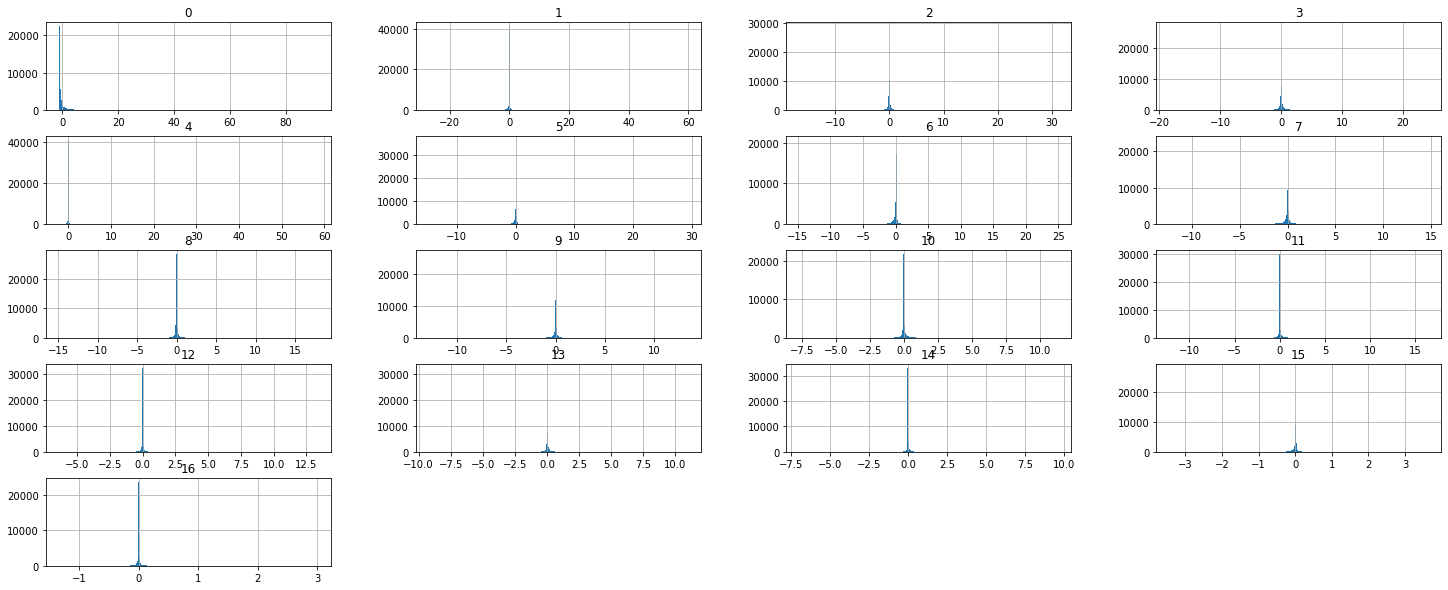

In [16]:
X_pca.hist(bins=500,figsize=(25,10))

Taking PCA components that results in 99.99% of the variance, reduces the feature space form 23 columns to 17 columns. 

## Model & Training

1. Logistic Regression
1. Decision Tree
1. XGBoost
1. Random Forest 
1. Opening Desicion Tree and Killing Underfitting and Overfitting nodes
1. Custom Decision Tree and Random Forest

1. Verifying using AutoML

In [24]:
# helper functions
# test train split for cross validation | spit ratio 75:25

X_pca_train, X_pca_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_pca, y, random_state=1
)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)


### Logistic Regression

__hypothesis function (softmax)__ 

$$
h_{\theta}(z) = \frac{e^{z_i}}{\sum_j^Ke^{z_j}}
$$

- Logistic Regression is a multiclass classifier and uses one vs all scheme for training.

              precision    recall  f1-score   support

           0       0.46      1.00      0.63      6803
           1       0.57      0.00      0.00      5152
           2       0.40      0.01      0.02      2752

    accuracy                           0.46     14707
   macro avg       0.48      0.34      0.22     14707
weighted avg       0.49      0.46      0.30     14707



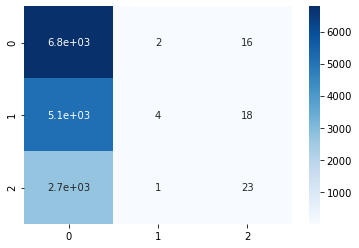

In [23]:
clf = LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000)
# had to increare the max_iter as it didn't converge earlier
# using X_pca to over the above mentioned Multicollinearity problem

clf.fit(X_pca_train, y_train)
clf.score(X_pca_train,y_train)
clf.score(X_pca_test,y_test)
    
y_pred = clf.predict(X_pca_test)

print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,y_pred),annot=True,cmap="Blues")
plt.show(sns)
clf=None

The resultant model is highly baised towards label0 and performs poorly on the other labels. 

### Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

Parameters used here:
- Max_Depth: maximum depth of tree upto which bifurgation is done based on features
- Criterion: The type of impurity measure used while splitting nodes. Entropy leads to creation of more balanced tree

DecisionTreeClassifier(criterion='entropy', max_depth=18)
0.44720201264703885
              precision    recall  f1-score   support

           0       0.49      0.64      0.55      6803
           1       0.41      0.34      0.37      5152
           2       0.32      0.19      0.24      2752

    accuracy                           0.45     14707
   macro avg       0.41      0.39      0.39     14707
weighted avg       0.43      0.45      0.43     14707



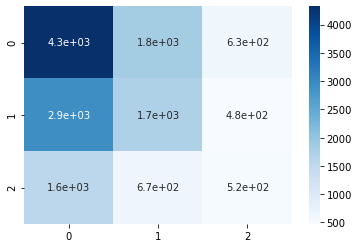

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scalar=scaler.transform(X)

X_scalar_train, X_scalar_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)
tree_clf=DecisionTreeClassifier(max_depth=18,criterion="entropy")
print(tree_clf.fit(X_scalar_train,y_train))
print(tree_clf.score(X_scalar_test,y_test))
y_pred = tree_clf.predict(X_scalar_test)
y_pred = [round(value) for value in y_pred]
print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,y_pred),annot=True,cmap="Blues")
plt.show(sns)
tree_clf=None

### XGBoost

XGBoost is a gradient boosting library. Here we have tried to test gradient boosting(type of ensemble algorithm) on decision trees to observe results and imporvement in performance. Further we have compared this with random forest(another type of ensemble algorithm)


/home/alpha91/miniconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.64      0.57      6803
           1       0.45      0.41      0.43      5152
           2       0.40      0.23      0.29      2752

    accuracy                           0.48     14707
   macro avg       0.46      0.43      0.43     14707
weighted avg       0.47      0.48      0.47     14707



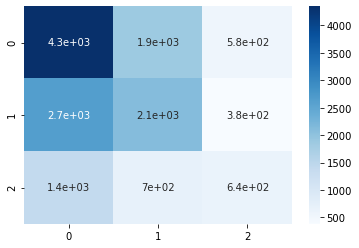

In [39]:
scaler = StandardScaler()
scaler.fit(X)
X_scalar=scaler.transform(X)

X_scalar_train, X_scalar_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

clf = XGBClassifier(max_depth=14)
clf.fit(X_train, y_train)

clf.score(X_scalar_train,y_train)
clf.score(X_scalar_test,y_test)
    
y_pred = clf.predict(X_scalar_test)
y_pred = [round(value) for value in y_pred]
print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,y_pred),annot=True,cmap="Blues")
plt.show(sns)
clf=None

### Random Forest

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean/average prediction of the individual trees.

Parameters used here:
- Max_Depth: maximum depth of tree upto which bifurgation is done based on features
- Criterion: The type of impurity measure used while splitting nodes. Entropy leads to creation of more balanced tree

Max_Depth: 2 :	 Train Accuracy:0.47	Test Accurary:0.472
Max_Depth: 4 :	 Train Accuracy:0.477	Test Accurary:0.476
Max_Depth: 6 :	 Train Accuracy:0.488	Test Accurary:0.48
Max_Depth: 8 :	 Train Accuracy:0.506	Test Accurary:0.484
Max_Depth: 10 :	 Train Accuracy:0.541	Test Accurary:0.487
Max_Depth: 12 :	 Train Accuracy:0.596	Test Accurary:0.489
Max_Depth: 14 :	 Train Accuracy:0.67	Test Accurary:0.492
Max_Depth: 16 :	 Train Accuracy:0.756	Test Accurary:0.499
Max_Depth: 18 :	 Train Accuracy:0.838	Test Accurary:0.493
Max_Depth: 20 :	 Train Accuracy:0.91	Test Accurary:0.487
Max_Depth: 22 :	 Train Accuracy:0.961	Test Accurary:0.482
Max_Depth: 24 :	 Train Accuracy:0.987	Test Accurary:0.478
Max_Depth: 26 :	 Train Accuracy:0.996	Test Accurary:0.477
Max_Depth: 28 :	 Train Accuracy:0.999	Test Accurary:0.469
Max_Depth: 30 :	 Train Accuracy:1.0	Test Accurary:0.471


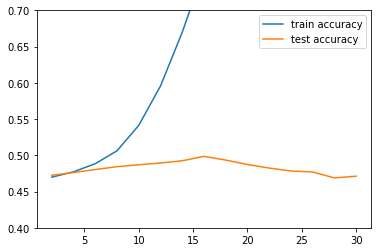

In [34]:
trainscores=[]
testscores=[]

for i in range(2,32,2):
    clf = RandomForestClassifier( max_depth=i,random_state=0)
    # Full overfit
    clf.fit(X_train, y_train)
    trainscore=clf.score(X_train,y_train)
    trainscores.append(trainscore)
    testscore=clf.score(X_test,y_test)
    testscores.append(testscore)
    
    print("Max_Depth: {} :\t Train Accuracy:{}\tTest Accurary:{}".format(i,np.around(trainscore,3),np.around(testscore,3)))

# plotting the score
plt.plot(range(2,32,2),trainscores,label="train accuracy")
plt.plot(range(2,32,2),testscores,label="test accuracy")
plt.ylim(0.4, 0.7)
plt.legend()
clf=None

RandomForestClassifier(criterion='entropy', max_depth=16)
0.49609029713741754
              precision    recall  f1-score   support

           0       0.50      0.80      0.61      6803
           1       0.48      0.29      0.36      5152
           2       0.59      0.14      0.23      2752

    accuracy                           0.50     14707
   macro avg       0.52      0.41      0.40     14707
weighted avg       0.51      0.50      0.45     14707



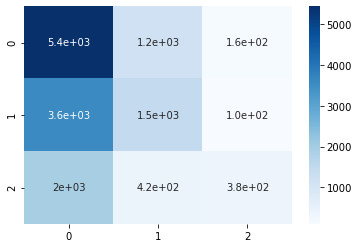

In [16]:
# TODO: best random forest model
# from sklearn.tree import RandomForestClassifier
scaler = StandardScaler()
scaler.fit(X)
X_scalar=scaler.transform(X)

X_scalar_train, X_scalar_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)
tree_clf=RandomForestClassifier(max_depth=16,criterion="entropy")
print(tree_clf.fit(X_scalar_train,y_train))
print(tree_clf.score(X_scalar_test,y_test))
y_pred = tree_clf.predict(X_scalar_test)
y_pred = [round(value) for value in y_pred]
print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,y_pred),annot=True,cmap="Blues")
plt.show(sns)
tree_clf=None


### Custom Random Forest Code

```python
# Build a decision tree
# Random Forest Algorithm on Sonar Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn.tree import DecisionTreeClassifier
class RandomForest():

    def __init__(self,trainX,trainY,testX,testY,sample_size,max_depth=3,n_trees=10,criterion="gini"):
        self.trees = list()
        self.trainX=trainX
        self.trainY=trainY
        self.testX=testX
        self.testY=testY
        self.sample_size=sample_size
        self.max_depth=max_depth
        self.n_trees=n_trees
        self.criterion=criterion
#         print(trainX)
        for i in range(n_trees):
            sampleX,sampleY = self.subsample(trainX,trainY, sample_size)
            tree = self.build_tree(sampleX,sampleY,criterion,max_depth)
            self.trees.append(tree)
        
        
    def build_tree(self,trainX,trainY,criterion, max_depth):
        root =  DecisionTreeClassifier(max_depth=max_depth,criterion=criterion)
        root.fit(trainX,trainY) 
        print(root.score(trainX,trainY))
        return root

    # Create a random subsample from the dataset with replacement
    def subsample(self,datasetX,datasetY, ratio):
#         print(len(datasetX),datasetX.shape,len(datasetY),datasetY.shape)
        sampleX = list()
        sampleY= list()
        datasetY=list(datasetY)
#         datasetX=list(datasetX)
        n_sample = round(len(datasetX) * ratio)
        while len(sampleX) < n_sample:
            index = randrange(len(datasetX))
            sampleX.append(datasetX.iloc[index])
            sampleY.append(datasetY[index])
        return sampleX,sampleY

    # Make a prediction with a list of bagged trees
    def bagging_predict(self, row):
        
        predictions = [int(tree.predict(np.array([row]))) for tree in self.trees]
        return max(set(predictions), key=predictions.count)

    # Random Forest Algorithm
    def predict(self,X):
#         print(self.testX)
        predictions=list()
        for row in X:
#             print(row)
            predictions.append(self.bagging_predict(row))
        return(predictions)

scaler = StandardScaler()
scaler.fit(X)
X_scalar=scaler.transform(X)

X_scalar_train, X_scalar_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1,test_size=0.20
)

tree_clf=RandomForest(X_scalar_train,y_train,X_scalar_test, y_test,sample_size=100,max_depth=16,criterion="entropy")
y_pred = tree_clf.predict(X_scalar_test)
y_pred = [round(value) for value in y_pred]
print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,y_pred),annot=True,cmap="Blues")
plt.show(sns)
tree_clf=None
```

![image](../Results/customRF_eval.png)

### Opening Decision Tree, Killing Overfitting/Underfitting Nodes

We see under the hood of decision tree class fro sklearn and manipulate the tree nodes in a way that we can eliminate nodes that may be overfitting. Doing this gives us a slight inncrease in performance. Elimination of nodes is done after observing the impurity value for each node and distribution of impurity values across the decision tree.

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X_scalar=scaler.transform(X)

X_scalar_train, X_scalar_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=7,test_size=0.20
)

from sklearn.tree import DecisionTreeClassifier

tree_clf=DecisionTreeClassifier(max_depth=20,criterion="entropy")
y_train[0]=3
tree_clf.fit(X_scalar_train,y_train)
score=tree_clf.score(X_scalar_test,y_test)
#Initial score for test
print(score)
tree=tree_clf.tree_
#check predicition values
print(tree.value.argmax(axis=2))
#check node impurities and decide which nodes to kill
print(tree.impurity)

# Kill nodes that are overfitting
for i in range(len(tree.impurity)):
    if  tree.impurity[i]<1:
        tree.value[i][0][3]=max(tree.value[i][0])+10
preds_X=tree_clf.predict(X_scalar_test)
y_test=np.array(y_test)
correct=0
total=len(preds_X)
for i in range(len(preds_X)):
    if(preds_X[i]==3):
        total-=1
    else:
        if(preds_X[i]==y_test[i]):
            correct+=1
        else:
            pass
print("Accuracy with some nodes killed: ",correct/total)

0.4476457589665137
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]
[1.50058298 1.48111189 1.42527407 ... 0.         0.         0.        ]
Accuracy with some nodes killed:  0.476216814159292


### Custom Decision Tree Code

In [17]:
class DecisionTreeClassifierCustom():
    # Init function that takes parameters
    def __init__(self,criterion="gini",prune='depth',max_depth=4,min_criterion=0.05):
        self.feature=None
        self.label=None
        self.n_sample=None
        self.gain=None
        self.left=None
        self.right=None
        self.threshold = None
        self.depth = 0

        self.root = None
        self.criterion = criterion
        self.prune = prune
        self.max_depth = max_depth
        self.min_criterion = min_criterion
    
    #create the fit methid    
    def fit(self, features, target):
        self.root = DecisionTreeClassifierCustom()
        self.root._grow_tree(features, target, self.criterion)
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    #predict after traversing the tree
    def predict(self, features):
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target, criterion = 'gini'):
        self.n_samples = features.shape[0] 

        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        if criterion in {'gini', 'entropy'}:
            self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key = lambda x : x[1])[0]

        impurity_node = self._calc_impurity(criterion, target)
        
        for col in range(features.shape[1]):
            feature_level = np.unique(features[:,col])
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0

            for threshold in thresholds:
                target_l = target[features[:,col] <= threshold]
                impurity_l = self._calc_impurity(criterion, target_l)
                n_l = float(target_l.shape[0]) / self.n_samples

                target_r = target[features[:,col] > threshold]
                impurity_r = self._calc_impurity(criterion, target_r)
                n_r = float(target_r.shape[0]) / self.n_samples

                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        self._split_tree(features, target, criterion)
    
    def _split_tree(self, features, target, criterion):
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = DecisionTreeClassifierCustom()
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l, criterion)

        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = DecisionTreeClassifierCustom()
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r, criterion)    
   
    def _calc_impurity(self, criterion, target):
        if criterion == 'gini':
            return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        elif criterion == 'mse':
            return np.mean((target - np.mean(target)) ** 2.0)
        else:
            entropy = 0.0
            for c in np.unique(target):
                p = float(len(target[target == c])) / target.shape[0]
                if p > 0.0:
                    entropy -= p * np.log2(p)
            return entropy            

    def _prune(self, method, max_depth, min_criterion, n_samples):
        if self.feature is None:
            return

        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)

        pruning = False

        if method == 'impurity' and self.left.feature is None and self.right.feature is None: 
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                pruning = True
        elif method == 'depth' and self.depth >= max_depth:
            pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        if self.feature != None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else: 
            return self.label

    def _show_tree(self, depth, cond):
        base = '    ' * depth + cond
        if self.feature != None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth+1, 'then ')
            self.right._show_tree(depth+1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')

In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import tree as sktree
print('\n\nClassification Tree')
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

cls = DecisionTreeClassifierCustom(criterion = 'entropy', prune = 'depth', max_depth = 3)
cls.fit(X_train, y_train)
cls.print_tree()

pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

clf = sktree.DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)

print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))



Classification Tree
 if X[2] <= 2.45
    then {value: 0, samples: 35}
    else if X[2] <= 4.75
        then if X[3] <= 1.65
            then {value: 1, samples: 34}
            else {value: 2, samples: 1}
        else if X[2] <= 5.15
            then {value: 2, samples: 16}
            else {value: 2, samples: 26}
This Classification Tree Prediction Accuracy:    0.9736842105263158
Sklearn Library Tree Prediction Accuracy:        0.9736842105263158


## AutoML

Trying AutoML to see if we can it can find a better model 

In [40]:
# excluding mlp/ANN
automl = autosklearn.classification.AutoSklearnClassifier(exclude_estimators=["mlp"],time_left_for_this_task=1800)
automl.fit(X_train, y_train)

[WARNING] [2021-04-11 15:25:14,181:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 114 not found
[WARNING] [2021-04-11 15:25:14,181:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 338 not found
[WARNING] [2021-04-11 15:25:14,181:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 43 not found
[WARNING] [2021-04-11 15:25:14,183:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 283 not found
[WARNING] [2021-04-11 15:25:14,184:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 576 not found
[WARNING] [2021-04-11 15:25:14,184:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 71 not found
[WARNING] [2021-04-11 15:25:14,185:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 162 not found
[WARNING] [2021-04-11 15:25:14,186:Client-AutoMLSMBO(1)::01f6e1b6-9aac-11eb-a3b9-1b73e785637b] Configuration 67 not found
[WARNING] [2021-04-

AutoSklearnClassifier(exclude_estimators=['mlp'], per_run_time_limit=180,
                      time_left_for_this_task=1800)

In [41]:
print(automl.show_models())

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'select_percentile_classification', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.8434454038631288, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 15, 'classifier:random_forest:min_samples_split': 3, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_p

In [42]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 01f6e1b6-9aac-11eb-a3b9-1b73e785637b
  Metric: accuracy
  Best validation score: 0.487294
  Number of target algorithm runs: 30
  Number of successful target algorithm runs: 3
  Number of crashed target algorithm runs: 12
  Number of target algorithms that exceeded the time limit: 8
  Number of target algorithms that exceeded the memory limit: 7



In [43]:
y_pred = automl.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred,zero_division=False))
X_test = None
X_train = None

              precision    recall  f1-score   support

           0       0.49      0.77      0.60      6803
           1       0.45      0.32      0.37      5152
           2       0.63      0.11      0.19      2752

    accuracy                           0.49     14707
   macro avg       0.52      0.40      0.39     14707
weighted avg       0.50      0.49      0.44     14707



# Results

The best ensemble model suggested by AutoML sklearn is a Random Forest, which has also been the best model we came across during our own venture. The best accuracy we have reached is 49.9% which same as that obtained by AutoML. 